In [ ]:
!pip install -q albumentations torchmetrics pytorch-lightning clearml python-dotenv

In [ ]:
import os
import math
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, TQDMProgressBar
from torch.utils.data import DataLoader, Dataset
from torchmetrics import JaccardIndex
from albumentations.pytorch import ToTensorV2
from clearml import Task
import cv2
import numpy as np
from google.colab import files
from dotenv import load_dotenv

In [ ]:
from google.colab import userdata, drive

os.environ['CLEARML_API_ACCESS_KEY'] = userdata.get('CLEARML_API_ACCESS_KEY')
os.environ['CLEARML_API_SECRET_KEY'] = userdata.get('CLEARML_API_SECRET_KEY')

In [ ]:
drive.mount('/content/drive')


source_path = '/content/drive/MyDrive/'

tasks = [
    {
        "files": ["leftImg8bit_trainvaltest.zip", "gtFine_trainvaltest.zip"],
        "dest": "/content/data/cityscapes/"
    }
]

for task in tasks:
    if not os.path.exists(task["dest"]):
        os.makedirs(task["dest"])

    for zip_file in task["files"]:
        full_path = os.path.join(source_path, zip_file)

        if os.path.exists(full_path):
            print(f"Unpacking {zip_file} in {task['dest']}...")
            !unzip -q -o "{full_path}" -d "{task['dest']}"
        else:
            print(f"Error, file not found: {full_path}")

Mounted at /content/drive
Unpacking leftImg8bit_trainvaltest.zip in /content/data/cityscapes/...
Unpacking gtFine_trainvaltest.zip in /content/data/cityscapes/...


In [ ]:
CONFIG = {
    "project_name": "Segmentation_Urban_Scene_CourseWork",
    "task_name": "DinoV2_Small_Cityscapes_FineTuning",
    "data_dir": "./data/cityscapes",
    "model_name": "dinov2_vits14",
    "classes": 19,
    "batch_size": 16,
    "lr": 1e-4,
    "weight_decay": 0.05,
    "epochs": 50,
    "image_size": (518, 1022),
    "freeze_backbone": False,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Set precision for Tensor Cores
torch.set_float32_matmul_precision('medium')

# Set allocator to avoid fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

task = Task.init(
    project_name=CONFIG["project_name"],
    task_name=CONFIG["task_name"],
    output_uri=False
)
task.connect(CONFIG)

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


ClearML Task: created new task id=d6b95dd73374435ea4c13acbae333f11


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


ClearML results page: https://app.clear.ml/projects/588d5d925230490b9f98b1007b4c7fa0/experiments/d6b95dd73374435ea4c13acbae333f11/output/log


{'project_name': 'Segmentation_Urban_Scene_CourseWork',
 'task_name': 'DinoV2_Small_Cityscapes_FineTuning',
 'data_dir': './data/cityscapes',
 'model_name': 'dinov2_vits14',
 'classes': 19,
 'batch_size': 16,
 'lr': 0.0001,
 'weight_decay': 0.05,
 'epochs': 50,
 'image_size': (518, 1022),
 'freeze_backbone': False,
 'device': 'cuda'}

In [ ]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', augmentation=None):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.masks_dir = os.path.join(root_dir, 'gtFine', split)
        self.augmentation = augmentation
        self.ids = []

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            mask_dir = os.path.join(self.masks_dir, city)
            for file_name in os.listdir(img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                   self.ids.append({
                       'image': os.path.join(img_dir, file_name),
                       'mask': os.path.join(mask_dir, file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png'))
                   })

        # Cityscapes to training labels mapping
        self.mapping = {
            7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9,
            23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
        }

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        sample = self.ids[i]
        image = cv2.imread(sample['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(sample['mask'], 0)

        # Map Cityscapes labels to training labels
        mask_mapped = np.ones_like(mask) * 255
        for k, v in self.mapping.items():
            mask_mapped[mask == k] = v
        mask = mask_mapped

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask.long()

In [ ]:
 class RoadDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, image_size):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size

    def setup(self, stage=None):
        # Training augmentations with resize to 518x1022
        # More aggressive augmentations for fine-tuning
        self.train_transform = A.Compose([
            A.Resize(height=518, width=1022),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.GaussianBlur(blur_limit=(3, 7), p=0.1),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        # Validation augmentations with resize to 518x1022
        self.valid_transform = A.Compose([
            A.Resize(height=518, width=1022),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        self.train_ds = CityscapesDataset(
            self.data_dir,
            split='train',
            augmentation=self.train_transform
        )
        self.val_ds = CityscapesDataset(
            self.data_dir,
            split='val',
            augmentation=self.valid_transform
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

In [ ]:
class LinearSegmentationHead(nn.Module):
    """
    Linear segmentation head for DINOv2.
    Handles patch-based features from DINOv2 (14x14 patches) and upsamples to full resolution.
    """
    def __init__(self, embed_dim=384, num_classes=19, patch_size=14):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        self.patch_size = patch_size

        # Simple linear classifier head
        self.linear = nn.Conv2d(embed_dim, num_classes, kernel_size=1)

    def forward(self, x, h, w):
        """
        Args:
            x: patch features from DINOv2, shape (B, N, C) where N = num_patches
            h, w: target output height and width
        Returns:
            logits: shape (B, num_classes, h, w)
        """
        B, N, C = x.shape

        # Calculate patch grid dimensions
        # For 518x1022 image with patch_size=14: 37 x 73 patches
        patch_h = h // self.patch_size
        patch_w = w // self.patch_size

        # Reshape to spatial dimensions: (B, C, patch_h, patch_w)
        x = x.reshape(B, patch_h, patch_w, C).permute(0, 3, 1, 2)

        # Apply linear classifier
        x = self.linear(x)

        # Upsample to original resolution using bilinear interpolation
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)

        return x


class ClearMLMetricsCallback(Callback):
    def __init__(self, task):
        super().__init__()
        self._logger = task.get_logger()

    def _log_metrics(self, trainer, stage):
        for name, value in trainer.callback_metrics.items():
            if isinstance(value, torch.Tensor):
                value = value.detach().cpu().item()
            if isinstance(value, (int, float)) and math.isfinite(value):
                self._logger.report_scalar(stage, name, value, iteration=trainer.current_epoch)

    def on_train_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "train")

    def on_validation_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "val")


class RoadModel(pl.LightningModule):
    def __init__(self, model_name='dinov2_vits14', num_classes=19, lr=1e-4,
                 weight_decay=0.05, epochs=50, freeze_backbone=True):
        super().__init__()
        self.save_hyperparameters()

        # Load DINOv2 small model from torch hub
        self.backbone = torch.hub.load('facebookresearch/dinov2', model_name)
        self.embed_dim = 384  # DINOv2 small embedding dimension
        self.patch_size = 14  # DINOv2 patch size

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Backbone frozen!")

        # Add segmentation head
        self.segmentation_head = LinearSegmentationHead(
            embed_dim=self.embed_dim,
            num_classes=num_classes,
            patch_size=self.patch_size
        )

        # Loss function
        self.criterion = nn.CrossEntropyLoss(ignore_index=255)

        # Metrics
        self.train_miou = JaccardIndex(task="multiclass", num_classes=num_classes, ignore_index=255)
        self.val_miou = JaccardIndex(task="multiclass", num_classes=num_classes, ignore_index=255)

    def forward(self, x):
        B, C, H, W = x.shape

        # Get patch features from DINOv2
        # DINOv2 returns features for each patch (removes CLS token)
        features = self.backbone.forward_features(x)

        # Remove CLS token (first token) and keep only patch tokens
        patch_features = features['x_norm_patchtokens']  # (B, N, embed_dim)

        # Pass through segmentation head
        logits = self.segmentation_head(patch_features, H, W)

        return logits

    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)

        loss = self.criterion(logits, masks)

        # Calculate mIoU
        preds = torch.argmax(logits, dim=1)
        miou = self.train_miou(preds, masks)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_miou", miou, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)

        loss = self.criterion(logits, masks)

        # Calculate mIoU
        preds = torch.argmax(logits, dim=1)
        miou = self.val_miou(preds, masks)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_miou", miou, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        # Only optimize segmentation head if backbone is frozen
        if self.hparams.freeze_backbone:
            params = self.segmentation_head.parameters()
        else:
            # Use different learning rates for backbone and head
            params = [
                {"params": self.segmentation_head.parameters(), "lr": self.hparams.lr},
                {"params": self.backbone.parameters(), "lr": self.hparams.lr * 0.1}
            ]

        optimizer = torch.optim.AdamW(
            params,
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
            betas=(0.9, 0.999),
            eps=1e-8
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.epochs,
            eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch"
            }
        }

In [ ]:
dm = RoadDataModule(
    CONFIG["data_dir"],
    CONFIG["batch_size"],
    CONFIG["image_size"]
)

model = RoadModel(
    model_name=CONFIG["model_name"],
    num_classes=CONFIG["classes"],
    lr=CONFIG["lr"],
    weight_decay=CONFIG["weight_decay"],
    epochs=CONFIG["epochs"],
    freeze_backbone=CONFIG["freeze_backbone"]
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_miou",
    dirpath="./checkpoints",
    filename="dinov2-small-cityscapes-{epoch:02d}-{val_miou:.4f}",
    save_top_k=1,
    mode="max",
)

trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="gpu",
    devices=1,
    logger=True,
    callbacks=[
        checkpoint_callback,
        TQDMProgressBar(refresh_rate=20),
        ClearMLMetricsCallback(task)
    ],
    precision="16-mixed",
    accumulate_grad_batches=4
)

trainer.fit(model, datamodule=dm)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning:

xFormers is not available (SwiGLU)

/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning:

xFormers is not available (Attention)

/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning:

xFormers is not available (Block)



Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 364MB/s]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/tmp/ipython-input-3154713499.py:16: UserWarning:

Argument(s) 'var_limit' are not valid for transform GaussNoise

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: UserWarning:

Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate

┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name              ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone          │ DinoVisionTransformer  │ 22.1 M │ train │     0 │
│ 1 │ segmentation_head │ LinearSegmentationHead │  7.3 K │ train │     0 │
│ 2 │ criterion         │ CrossEntropyLoss       │      0 │ train │     0 │
│ 3 │ train_miou        │ MulticlassJaccardIndex │      0 │ train │     0 │
│ 4 │ val_miou          │ MulticlassJaccardIndex │      0 │ train │     0 │
└───┴───────────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 22.1 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.1 M                                                                                               
Total estimated model params size (MB): 88                                                                         
Modules in train mode: 204                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Connecting multiple input models with the same name: `dinov2_vits14_pretrain`. This might result in the wrong model being used when executing remotely
/tmp/ipython-input-3154713499.py:16: UserWarning:

Argument(s) 'var_limit' are not valid for transform GaussNoise

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.16353578865528107    │
│         val_miou          │    0.6292412877082825     │
└───────────────────────────┴───────────────────────────┘


Results:



,Metric,Value
0,Loss,0.1635
1,mIoU,0.6292
2,Percent,62.92%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



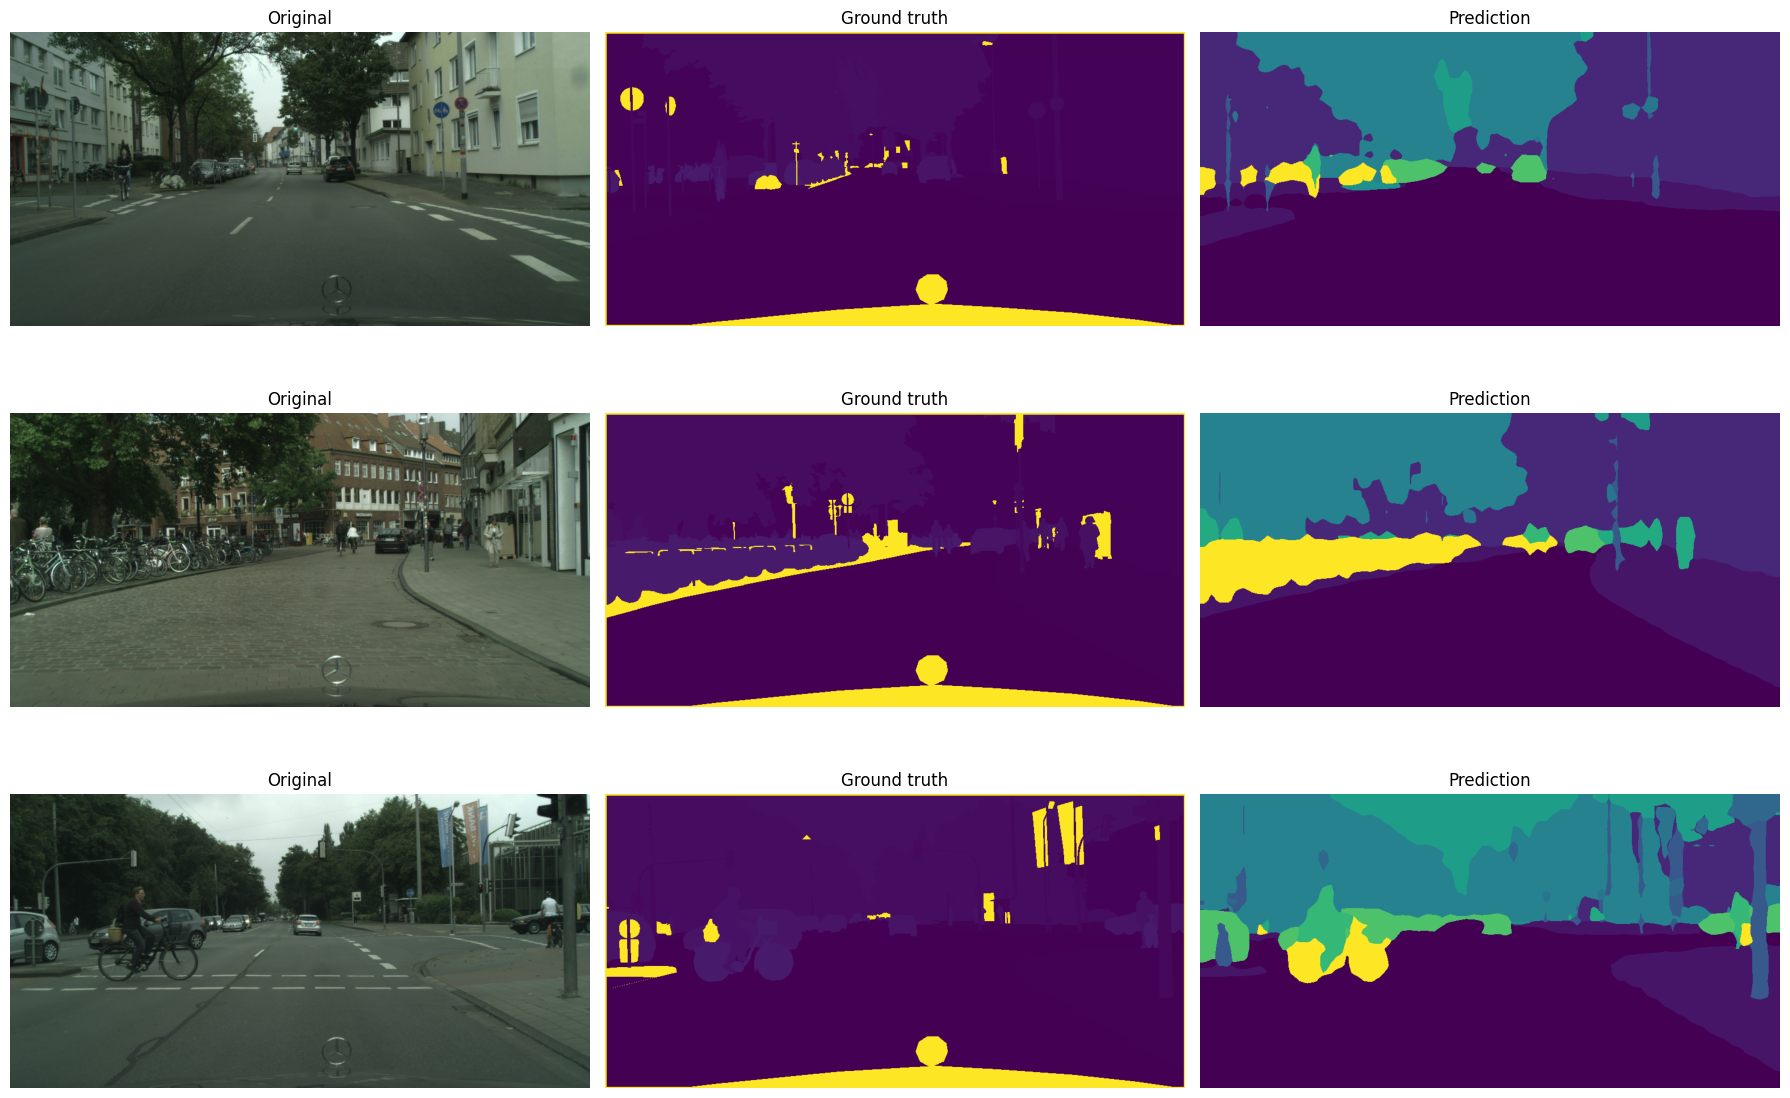

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path

best_model = RoadModel.load_from_checkpoint(best_model_path)
best_model.to(CONFIG["device"])
best_model.eval()

# Validate the best model
val_results = trainer.validate(best_model, datamodule=dm)[0]

metrics_data = {
    "Metric": ["Loss", "mIoU", "Percent"],
    "Value": [
        f"{val_results['val_loss']:.4f}",
        f"{val_results['val_miou']:.4f}",
        f"{val_results['val_miou']*100:.2f}%"
    ]
}
df = pd.DataFrame(metrics_data)

print("\n" + "="*30)
print("Results:" + "\n")
print("="*30)
display(df)

def visualize_predictions(model, datamodule, num_samples=3):
    model.to(CONFIG["device"])
    model.eval()

    val_loader = datamodule.val_dataloader()
    images, masks = next(iter(val_loader))

    images = images.to(CONFIG["device"])
    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(18, num_samples * 4))

    for i in range(min(num_samples, len(images))):
        # Denormalize image for visualization
        img = images[i].permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i])
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i])
        plt.title(f"Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, dm)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path

model_name = os.path.basename(best_model_path)

current_task = Task.get_task(task_id=task.id)

current_task.update_output_model(
    model_path=best_model_path,
    model_name=model_name,
    iteration=trainer.current_epoch
)

'https://files.clear.ml/Segmentation_Urban_Scene_CourseWork/DinoV2_Small_Cityscapes_FineTuning.d6b95dd73374435ea4c13acbae333f11/models/dinov2-small-cityscapes-epoch=48-val_miou=0.6292.ckpt'

In [ ]:
task.close()